In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset paths
import os

# Change this to your actual dataset location in Drive
DATA_DIR = "/content/drive/MyDrive/chest_xray_dataset"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

print("Train:", TRAIN_DIR)
print("Val:", VAL_DIR)
print("Test:", TEST_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train: /content/drive/MyDrive/chest_xray_dataset/train
Val: /content/drive/MyDrive/chest_xray_dataset/val
Test: /content/drive/MyDrive/chest_xray_dataset/test


In [3]:
!pip install torchxrayvision --quiet

In [28]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# TorchXRayVision normalization transform
class ToHU:
    """Convert pixel range [0,1] to [-1024, 1024]"""
    def __call__(self, tensor):
        return tensor * (1024 + 1024) - 1024

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ToHU()
])

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset   = datasets.ImageFolder(VAL_DIR,   transform=transform)
test_dataset  = datasets.ImageFolder(TEST_DIR,  transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train size: 5216, Val size: 16, Test size: 624
Classes: ['NORMAL', 'PNEUMONIA']


In [29]:
import torch.nn as nn
import torchxrayvision as xrv

class PneumoniaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained DenseNet121
        self.backbone = xrv.models.DenseNet(weights="densenet121-res224-all")
        # Global average pooling to get (batch_size, 1024)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # Binary classifier head
        self.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        feats = self.backbone.features(x)           # (B, 1024, H, W)
        pooled = self.pool(feats)                   # (B, 1024, 1, 1)
        flattened = pooled.view(pooled.size(0), -1) # (B, 1024)
        out = self.classifier(flattened)            # (B, 2)
        return out

model = PneumoniaClassifier().to(device)

In [30]:
import torch.optim as optim

# Freeze all layers except classifier (optional, speeds up training & avoids overfitting)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Loss function for binary classification
criterion = nn.CrossEntropyLoss()

# Optimizer (only classifier parameters)
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

In [33]:
import torch

num_epochs = 5
best_val_acc = 0.0
best_model_wts = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels).item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()

    # Calculate metrics
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    train_acc = train_correct / len(train_dataset)
    val_acc = val_correct / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict().copy()
        torch.save(best_model_wts, "best_model.pth")
        print(f"✅ New best model saved with val_acc: {best_val_acc:.4f}")

# Optionally, load best model weights back into model
model.load_state_dict(torch.load("best_model.pth"))

Epoch [1/5] Train Loss: 0.1965 Train Acc: 0.9254 Val Loss: 0.5724 Val Acc: 0.6875
✅ New best model saved with val_acc: 0.6875
Epoch [2/5] Train Loss: 0.1791 Train Acc: 0.9312 Val Loss: 0.5686 Val Acc: 0.7500
✅ New best model saved with val_acc: 0.7500
Epoch [3/5] Train Loss: 0.1677 Train Acc: 0.9362 Val Loss: 0.6485 Val Acc: 0.6875
Epoch [4/5] Train Loss: 0.1646 Train Acc: 0.9408 Val Loss: 0.6607 Val Acc: 0.6875
Epoch [5/5] Train Loss: 0.1639 Train Acc: 0.9373 Val Loss: 0.7137 Val Acc: 0.6875


<All keys matched successfully>

In [35]:
!cp best_model.pth /content/drive/MyDrive/chest_xray_dataset

Test Loss: 0.3109 | Test Accuracy: 0.8590


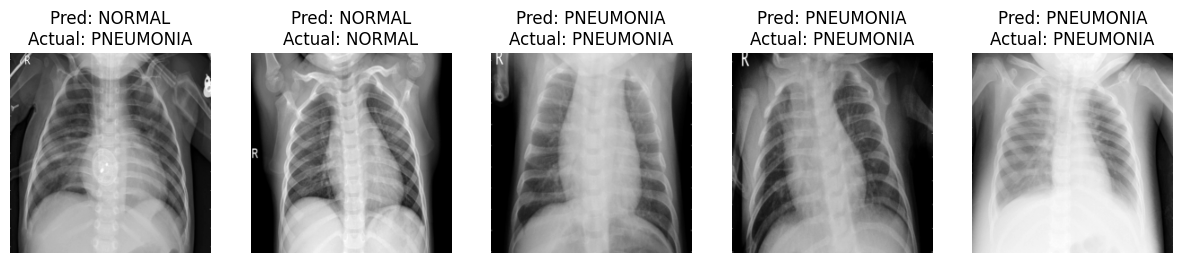

In [36]:
import torch
import matplotlib.pyplot as plt
import random

model.eval()

# Evaluation on test set
test_loss = 0.0
test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels).item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_dataset)
test_acc = test_correct / len(test_dataset)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Show 5 random test images with predicted vs actual labels
class_names = ['NORMAL', 'PNEUMONIA']
indices = random.sample(range(len(test_dataset)), 5)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    model_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(model_input)
        _, pred = torch.max(output, 1)

    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # normalize for display

    plt.subplot(1, 5, i+1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Pred: {class_names[pred.item()]}\nActual: {class_names[label]}")
    plt.axis("off")

plt.show()